In [90]:
import pyspark.sql
from pyspark.sql import SparkSession
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pyspark.sql.functions import col, when, count, sum, avg, max, min, udf
from pyspark.ml.feature import Imputer, StringIndexer, VectorAssembler, StandardScaler, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification  import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [3]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.3-py2.py3-none-any.whl size=317840625 sha256=e5ff2e9916223ad00488df2a530642fc0325db2344a03a8bd6986e825a288ed8
  Stored in directory: /root/.cache/pip/wheels/1b/3a/92/28b93e2fbfdbb07509ca4d6f50c5e407f48dce4ddbda69a4ab
Successfully built pyspark


In [5]:
spark = SparkSession.builder.appName("mypysparkproject").getOrCreate()
spark

In [10]:
df = spark.read.csv('/content/dataset.csv', header = True )
df.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|           No|    Yes|        No|     1|  

In [11]:
df.describe().show()

+-------+----------+------+-------------+-------+----------+------------------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+------------------+------------------+-----+
|summary|customerID|gender|SeniorCitizen|Partner|Dependents|            tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|    MonthlyCharges|      TotalCharges|Churn|
+-------+----------+------+-------------+-------+----------+------------------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+------------------+------------------+-----+
|  count|      7043|  7043|         7043|   7043|      7043|              7043|      

In [17]:
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|         0|     0|            0|      0|         0|     0|           0|            0|              0|             0|           0|               0|          0|          0|              0|       0|               0| 

In [18]:
df.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: string (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: string (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: string (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)



In [21]:
df.createOrReplaceTempView("customers")

In [27]:
result = spark.sql("""
SELECT * FROM customers
WHERE churn = 'Yes'
""")
result.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|3668-QPYBK|  Male|           No|     No|        No|     2|  

In [35]:
test = result.toPandas()
test.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
1,9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.7,151.65,Yes
2,9305-CDSKC,Female,No,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
3,7892-POOKP,Female,No,Yes,No,28,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.8,3046.05,Yes
4,0280-XJGEX,Male,No,No,No,49,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.7,5036.3,Yes


In [36]:
df.createOrReplaceTempView("customers")

In [39]:
test = spark.sql("""
SELECT gender, Contract FROM customers
where Churn =='Yes' and Monthlycharges > 40
""")
test.show()

+------+--------------+
|gender|      Contract|
+------+--------------+
|  Male|Month-to-month|
|Female|Month-to-month|
|Female|Month-to-month|
|Female|Month-to-month|
|  Male|Month-to-month|
|Female|Month-to-month|
|  Male|Month-to-month|
|Female|Month-to-month|
|  Male|Month-to-month|
|  Male|Month-to-month|
|Female|Month-to-month|
|Female|Month-to-month|
|Female|Month-to-month|
|Female|Month-to-month|
|  Male|Month-to-month|
|Female|Month-to-month|
|Female|Month-to-month|
|Female|Month-to-month|
|Female|Month-to-month|
|Female|Month-to-month|
+------+--------------+
only showing top 20 rows



In [42]:
len(df.columns)

21

In [43]:
df.count()

7043

In [46]:
df.groupBy('Churn', 'gender', 'Paymentmethod').count().show()

+-----+------+--------------------+-----+
|Churn|gender|       Paymentmethod|count|
+-----+------+--------------------+-----+
|  Yes|  Male|        Mailed check|  158|
|  Yes|Female|    Electronic check|  522|
|  Yes|Female|Bank transfer (au...|  136|
|   No|Female|Credit card (auto...|  621|
|   No|  Male|Bank transfer (au...|  634|
|   No|Female|        Mailed check|  628|
|  Yes|Female|Credit card (auto...|  131|
|  Yes|  Male|Credit card (auto...|  101|
|  Yes|  Male|    Electronic check|  549|
|   No|Female|    Electronic check|  648|
|  Yes|  Male|Bank transfer (au...|  122|
|   No|Female|Bank transfer (au...|  652|
|  Yes|Female|        Mailed check|  150|
|   No|  Male|    Electronic check|  646|
|   No|  Male|Credit card (auto...|  669|
|   No|  Male|        Mailed check|  676|
+-----+------+--------------------+-----+



In [56]:
df.dtypes

[('customerID', 'string'),
 ('gender', 'string'),
 ('SeniorCitizen', 'string'),
 ('Partner', 'string'),
 ('Dependents', 'string'),
 ('tenure', 'string'),
 ('PhoneService', 'string'),
 ('MultipleLines', 'string'),
 ('InternetService', 'string'),
 ('OnlineSecurity', 'string'),
 ('OnlineBackup', 'string'),
 ('DeviceProtection', 'string'),
 ('TechSupport', 'string'),
 ('StreamingTV', 'string'),
 ('StreamingMovies', 'string'),
 ('Contract', 'string'),
 ('PaperlessBilling', 'string'),
 ('PaymentMethod', 'string'),
 ('MonthlyCharges', 'string'),
 ('TotalCharges', 'string'),
 ('Churn', 'string')]

In [59]:
numerical = [name for name, typ in df.dtypes if typ=="string"]
numerical

['customerID',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'Churn']

In [60]:
numerical_col = [ 'MonthlyCharges',
 'TotalCharges', 'tenure']
categorical_col = ['customerID',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn']

In [61]:
from pyspark.sql.types import FloatType, IntegerType

for column_name in numerical_col:
  df = df.withColumn(column_name, df[column_name].cast(FloatType()))
for column_name in categorical_col:
  df = df.withColumn(column_name, df[column_name].cast("string"))

df.printSchema()


root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: string (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: float (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: float (nullable = true)
 |-- TotalCharges: float (nullable = true)
 |-- Churn: string (nullable = true)



In [69]:
columns = ['customerID',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',]

for col in columns:
      df.crosstab(col, 'Churn').show()

+----------------+---+---+
|customerID_Churn| No|Yes|
+----------------+---+---+
|      3528-HFRIQ|  1|  0|
|      0356-ERHVT|  1|  0|
|      6479-OAUSD|  1|  0|
|      3195-TQDZX|  1|  0|
|      6718-BDGHG|  1|  0|
|      3692-JHONH|  1|  0|
|      6234-RAAPL|  1|  0|
|      0953-LGOVU|  1|  0|
|      4868-AADLV|  1|  0|
|      5859-HZYLF|  1|  0|
|      1450-SKCVI|  0|  1|
|      7661-CPURM|  1|  0|
|      3668-QPYBK|  0|  1|
|      0786-VSSUD|  0|  1|
|      2712-SYWAY|  1|  0|
|      9921-QFQUL|  1|  0|
|      2592-YKDIF|  1|  0|
|      5668-MEISB|  1|  0|
|      6383-ZTSIW|  1|  0|
|      7244-KXYZN|  1|  0|
+----------------+---+---+
only showing top 20 rows

+------------+----+---+
|gender_Churn|  No|Yes|
+------------+----+---+
|      Female|2549|939|
|        Male|2625|930|
+------------+----+---+

+-------------------+----+----+
|SeniorCitizen_Churn|  No| Yes|
+-------------------+----+----+
|                 No|4508|1393|
|                Yes| 666| 476|
+-------------------+

In [71]:
data = df.select(numerical_col).toPandas()
data.head()

,MonthlyCharges,TotalCharges,tenure
0,29.850000,29.850000,1.0
1,56.950001,1889.500000,34.0
2,53.849998,108.150002,2.0
3,42.299999,1840.750000,45.0
4,70.699997,151.649994,2.0


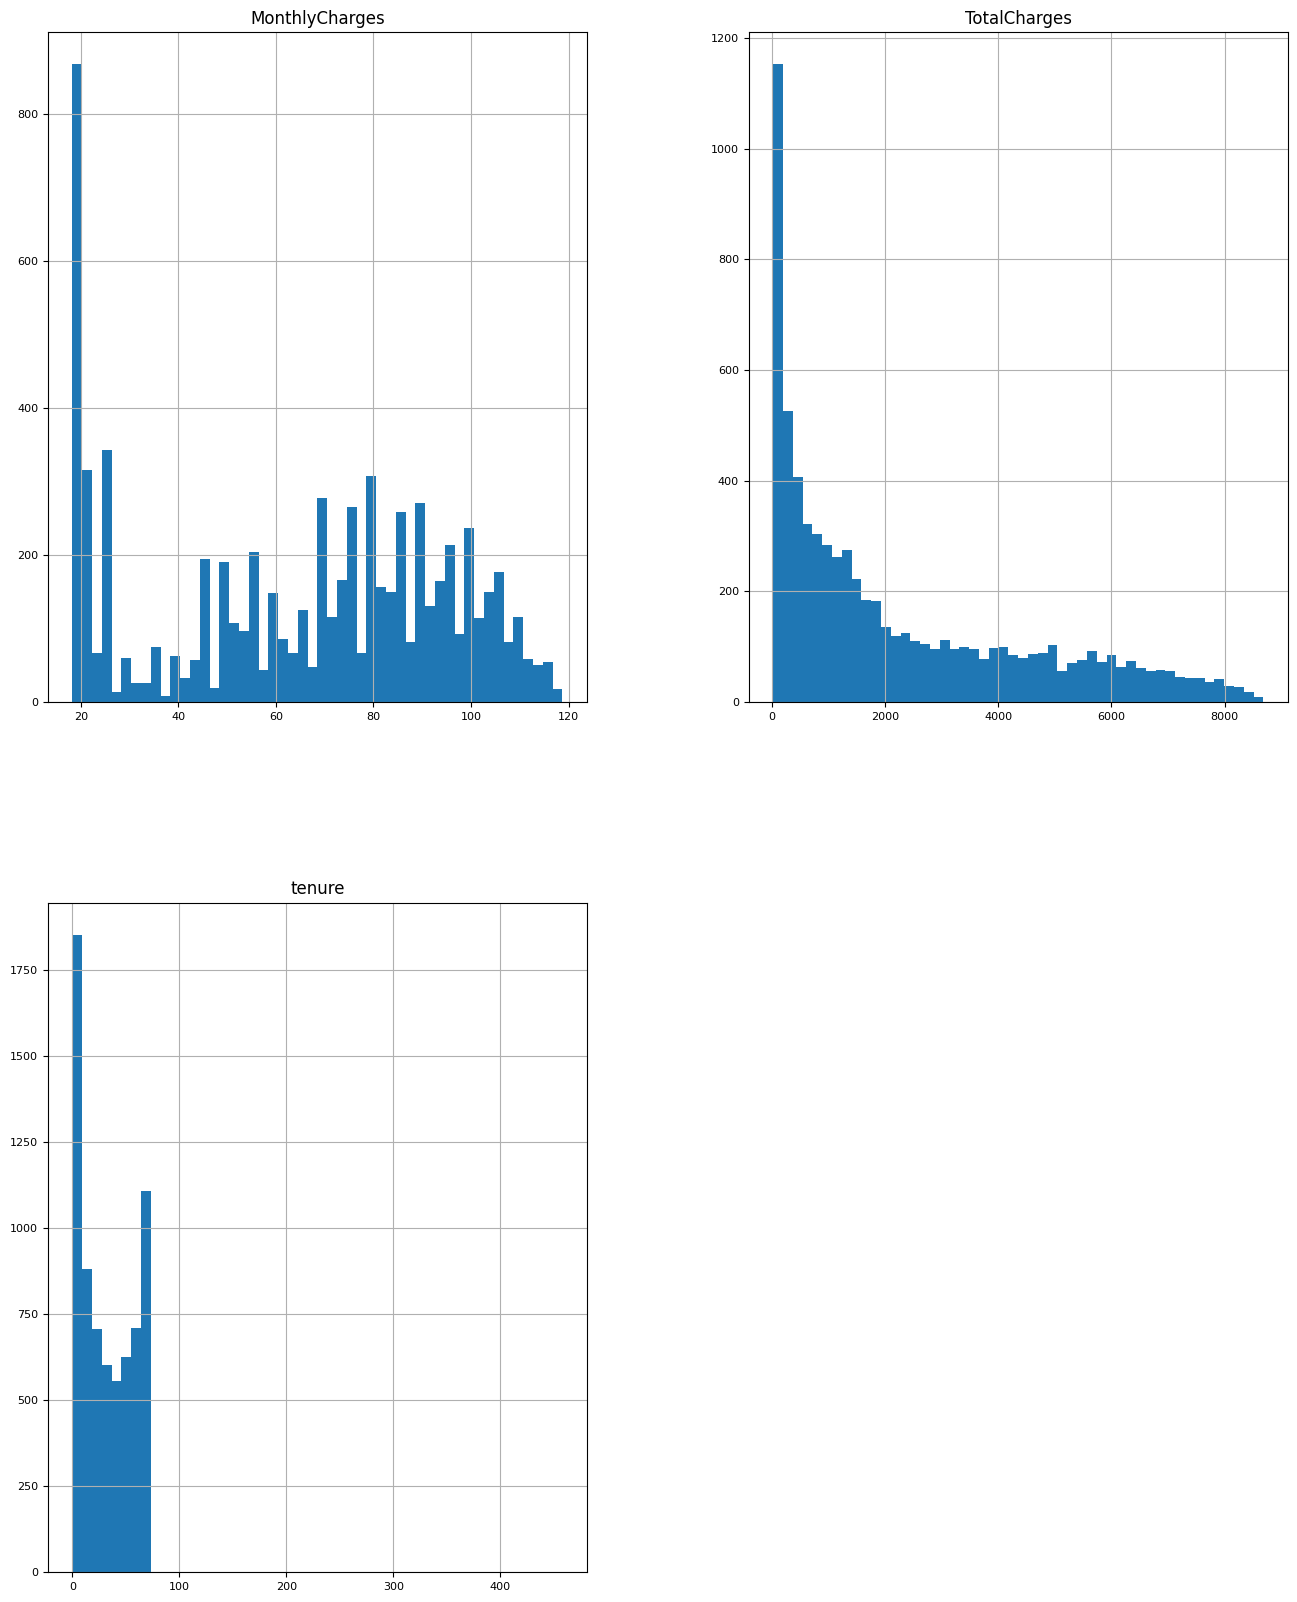

In [75]:
data.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

In [78]:
data.tenure.describe()

,tenure
count,7043.000000
mean,32.435753
std,25.075197
min,0.000000
25%,9.000000
50%,29.000000
75%,55.000000
max,458.000000


In [79]:
data.corr()

,MonthlyCharges,TotalCharges,tenure
MonthlyCharges,1.000000,0.651065,0.243703
TotalCharges,0.651065,1.000000,0.806530
tenure,0.243703,0.806530,1.000000


In [85]:
cat_data = df.select(categorical_col)
cat_data.show()

+----------+------+-------------+-------+----------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|Churn|
+----------+------+-------------+-------+----------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+-----+
|7590-VHVEG|Female|           No|    Yes|        No|          No|No phone service|            DSL|                 No|                Yes|                 No|        

In [89]:
for col1 in cat_data.columns:
  cat_data.groupBy(col1).count().orderBy('count', ascending=False).show()

+----------+-----+
|customerID|count|
+----------+-----+
|3668-QPYBK|    1|
|6234-RAAPL|    1|
|1894-IGFSG|    1|
|6982-SSHFK|    1|
|5859-HZYLF|    1|
|6479-OAUSD|    1|
|2592-YKDIF|    1|
|6718-BDGHG|    1|
|3195-TQDZX|    1|
|4248-QPAVC|    1|
|5668-MEISB|    1|
|5802-ADBRC|    1|
|2712-SYWAY|    1|
|2011-TRQYE|    1|
|7244-KXYZN|    1|
|0953-LGOVU|    1|
|3623-FQBOX|    1|
|3692-JHONH|    1|
|3528-HFRIQ|    1|
|7661-CPURM|    1|
+----------+-----+
only showing top 20 rows

+------+-----+
|gender|count|
+------+-----+
|  Male| 3555|
|Female| 3488|
+------+-----+

+-------------+-----+
|SeniorCitizen|count|
+-------------+-----+
|           No| 5901|
|          Yes| 1142|
+-------------+-----+

+-------+-----+
|Partner|count|
+-------+-----+
|     No| 3641|
|    Yes| 3402|
+-------+-----+

+----------+-----+
|Dependents|count|
+----------+-----+
|        No| 4933|
|       Yes| 2110|
+----------+-----+

+------------+-----+
|PhoneService|count|
+------------+-----+
|         Yes| 6361

In [88]:
cat_data.summary().show()

+-------+----------+------+-------------+-------+----------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+-----+
|summary|customerID|gender|SeniorCitizen|Partner|Dependents|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|Churn|
+-------+----------+------+-------------+-------+----------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+-----+
|  count|      7043|  7043|         7043|   7043|      7043|        7043|         7043|           7043|          7043|        7043|            7043|       7043|       7043|           7043|          7043|            7043|                7043| 7043|
|   mean

In [100]:
for column in cat_data.columns:
  cat_data.select(count(when(col(column).isNull(), column)).alias(column)).show()

+----------+
|customerID|
+----------+
|         0|
+----------+

+------+
|gender|
+------+
|     0|
+------+

+-------------+
|SeniorCitizen|
+-------------+
|            0|
+-------------+

+-------+
|Partner|
+-------+
|      0|
+-------+

+----------+
|Dependents|
+----------+
|         0|
+----------+

+------------+
|PhoneService|
+------------+
|           0|
+------------+

+-------------+
|MultipleLines|
+-------------+
|            0|
+-------------+

+---------------+
|InternetService|
+---------------+
|              0|
+---------------+

+--------------+
|OnlineSecurity|
+--------------+
|             0|
+--------------+

+------------+
|OnlineBackup|
+------------+
|           0|
+------------+

+----------------+
|DeviceProtection|
+----------------+
|               0|
+----------------+

+-----------+
|TechSupport|
+-----------+
|          0|
+-----------+

+-----------+
|StreamingTV|
+-----------+
|          0|
+-----------+

+---------------+
|StreamingMovies|
+-----

In [101]:
df.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: string (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: float (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: float (nullable = true)
 |-- TotalCharges: float (nullable = true)
 |-- Churn: string (nullable = true)



In [126]:
from pyspark.sql.functions import col


df = df.withColumn("TotalCharges", col("TotalCharges").cast("float"))


impute_column = ['TotalCharges']
imputer = Imputer(inputCols=impute_column, outputCols=impute_column, strategy='mean')
model = imputer.fit(df).transform(df)

model.show()




+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|           No|    Yes|        No|   1.0|  

In [117]:
for column in model.columns:
  model.select(count(when(col(column).isNull(), column)).alias(column)).show()

+----------+
|customerID|
+----------+
|         0|
+----------+

+------+
|gender|
+------+
|     0|
+------+

+-------------+
|SeniorCitizen|
+-------------+
|            0|
+-------------+

+-------+
|Partner|
+-------+
|      0|
+-------+

+----------+
|Dependents|
+----------+
|         0|
+----------+

+------+
|tenure|
+------+
|     0|
+------+

+------------+
|PhoneService|
+------------+
|           0|
+------------+

+-------------+
|MultipleLines|
+-------------+
|            0|
+-------------+

+---------------+
|InternetService|
+---------------+
|              0|
+---------------+

+--------------+
|OnlineSecurity|
+--------------+
|             0|
+--------------+

+------------+
|OnlineBackup|
+------------+
|           0|
+------------+

+----------------+
|DeviceProtection|
+----------------+
|               0|
+----------------+

+-----------+
|TechSupport|
+-----------+
|          0|
+-----------+

+-----------+
|StreamingTV|
+-----------+
|          0|
+----------

In [118]:
model.select(count(when(col('tenure') > 100, 'tenure'))).show()

+-----------------------------------------------+
|count(CASE WHEN (tenure > 100) THEN tenure END)|
+-----------------------------------------------+
|                                              1|
+-----------------------------------------------+



In [120]:
model.select("*").where(model.tenure > 100).show()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+----------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|   PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+----------------+--------------+------------+-----+
|5122-CYFXA|Female|           No|     No|        No| 458.0|         Yes|           No|            DSL|            No|         Yes|              No|        Yes|        Yes|            Yes|

In [127]:
print(model.count())
model = model.filter(model.tenure < 100)
model.show()
print(" outlier is removed")
print(model.count())

7043
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|           No|    Yes|        No|   1

In [128]:
numerical_vector = VectorAssembler(inputCols=numerical_col, outputCol='numerical_vectors')
numerical_vector = numerical_vector.transform(model)
numerical_vector.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+--------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|   numerical_vectors|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+--------------------

In [129]:
standarise_vector = StandardScaler(inputCol='numerical_vectors', outputCol='standarise_vectors', withStd=True, withMean=True)
standarise_vector = standarise_vector.fit(numerical_vector).transform(numerical_vector)
standarise_vector.show()


+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+--------------------+--------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|   numerical_vectors|  standarise_vectors|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+------------

In [131]:
categorical_column_indexed = [name + "_indexed" for name in categorical_col ]

In [132]:
categorical_column_indexed

['customerID_indexed',
 'gender_indexed',
 'SeniorCitizen_indexed',
 'Partner_indexed',
 'Dependents_indexed',
 'PhoneService_indexed',
 'MultipleLines_indexed',
 'InternetService_indexed',
 'OnlineSecurity_indexed',
 'OnlineBackup_indexed',
 'DeviceProtection_indexed',
 'TechSupport_indexed',
 'StreamingTV_indexed',
 'StreamingMovies_indexed',
 'Contract_indexed',
 'PaperlessBilling_indexed',
 'PaymentMethod_indexed',
 'Churn_indexed']

In [134]:
indexer = StringIndexer(inputCols=categorical_col, outputCols=categorical_column_indexed)
indexed = indexer.fit(standarise_vector).transform(standarise_vector)
indexed.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+--------------------+--------------------+------------------+--------------+---------------------+---------------+------------------+--------------------+---------------------+-----------------------+----------------------+--------------------+------------------------+-------------------+-------------------+-----------------------+----------------+------------------------+---------------------+-------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMetho

In [136]:
categorical_column_indexed.remove('Churn_indexed')
categorical_column_indexed.remove('customerID_indexed')

categorical_column_indexed


['gender_indexed',
 'SeniorCitizen_indexed',
 'Partner_indexed',
 'Dependents_indexed',
 'PhoneService_indexed',
 'MultipleLines_indexed',
 'InternetService_indexed',
 'OnlineSecurity_indexed',
 'OnlineBackup_indexed',
 'DeviceProtection_indexed',
 'TechSupport_indexed',
 'StreamingTV_indexed',
 'StreamingMovies_indexed',
 'Contract_indexed',
 'PaperlessBilling_indexed',
 'PaymentMethod_indexed']

In [137]:
vector2 = VectorAssembler(inputCols=categorical_column_indexed, outputCol='categorical_vectors')
final = vector2.transform(indexed)
final.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+--------------------+--------------------+------------------+--------------+---------------------+---------------+------------------+--------------------+---------------------+-----------------------+----------------------+--------------------+------------------------+-------------------+-------------------+-----------------------+----------------+------------------------+---------------------+-------------+--------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBillin

In [138]:
final_vector = VectorAssembler(inputCols=['standarise_vectors', 'categorical_vectors'], outputCol='final_feature_vector')
final_data = final_vector.transform(final)


final_data.select('final_feature_vector', 'Churn_indexed').show()

+--------------------+-------------+
|final_feature_vector|Churn_indexed|
+--------------------+-------------+
|(19,[0,1,2,3,5,7,...|          0.0|
|(19,[0,1,2,9,10,1...|          0.0|
|(19,[0,1,2,9,10,1...|          1.0|
|[-0.7463862549342...|          0.0|
|(19,[0,1,2,3],[0....|          1.0|
|(19,[0,1,2,3,8,12...|          1.0|
|(19,[0,1,2,6,8,11...|          0.0|
|(19,[0,1,2,3,7,8,...|          0.0|
|(19,[0,1,2,3,5,8,...|          1.0|
|(19,[0,1,2,6,9,10...|          0.0|
|(19,[0,1,2,5,6,9,...|          0.0|
|[-1.5223419648353...|          0.0|
|(19,[0,1,2,5,8,12...|          0.0|
|(19,[0,1,2,8,11,1...|          1.0|
|(19,[0,1,2,10,12,...|          0.0|
|[1.61138941132565...|          0.0|
|[-1.4658484357122...|          0.0|
|[1.39372291881971...|          0.0|
|(19,[0,1,2,3,5,6,...|          1.0|
|(19,[0,1,2,3,11,1...|          0.0|
+--------------------+-------------+
only showing top 20 rows



In [140]:
train, test = final_data.randomSplit([0.7, 0.3], seed=102)
train.show()
test.show()
train.count()
test.count()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+--------------------+--------------------+------------------+--------------+---------------------+---------------+------------------+--------------------+---------------------+-----------------------+----------------------+--------------------+------------------------+-------------------+-------------------+-----------------------+----------------+------------------------+---------------------+-------------+--------------------+--------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Con

2188

In [145]:
dec_tree = DecisionTreeClassifier(featuresCol='final_feature_vector', labelCol='Churn_indexed', maxDepth=4)
dec_tree_model = dec_tree.fit(train)
dec_tree_model

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_41f5df9339f7, depth=4, numNodes=17, numClasses=2, numFeatures=19

In [143]:
lr = LogisticRegression(featuresCol='final_feature_vector', labelCol='Churn_indexed', regParam=0.01, elasticNetParam=1)
lr_model = lr.fit(train)
lr_model.summary.areaUnderROC


0.8355979597762542

In [149]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol='final_feature_vector', labelCol='Churn_indexed', numTrees=500, maxDepth=4, seed=1354)
rf_model = rf.fit(train)
rf_model.summary.areaUnderROC

0.840238756581145

In [142]:
predictions = dec_tree_model.transform(test)
predictions.select('final_feature_vector', 'Churn_indexed', 'prediction').show()

+--------------------+-------------+----------+
|final_feature_vector|Churn_indexed|prediction|
+--------------------+-------------+----------+
|(19,[0,1,2,8,9,15...|          0.0|       0.0|
|(19,[0,1,2,4,5,11...|          1.0|       1.0|
|(19,[0,1,2,3,6,9,...|          0.0|       0.0|
|[1.49341744909059...|          0.0|       0.0|
|(19,[0,1,2,4,9,10...|          1.0|       0.0|
|(19,[0,1,2,4,7,8,...|          1.0|       1.0|
|(19,[0,1,2,3,5,6,...|          0.0|       0.0|
|[-1.4924336184308...|          0.0|       0.0|
|[-1.4974183322675...|          0.0|       0.0|
|(19,[0,1,2,5,6,14...|          0.0|       0.0|
|[-1.4691715993981...|          0.0|       0.0|
|[-1.3179681904568...|          0.0|       0.0|
|[-1.4774794769206...|          0.0|       0.0|
|(19,[0,1,2,9,18],...|          0.0|       1.0|
|[0.54798108843628...|          0.0|       0.0|
|(19,[0,1,2,3,4,14...|          0.0|       0.0|
|(19,[0,1,2,8,9,11...|          0.0|       0.0|
|[1.70277606407396...|          0.0|    

In [150]:
predictions1 = lr_model.transform(test)
predictions1.select('final_feature_vector', 'Churn_indexed', 'prediction').show()

+--------------------+-------------+----------+
|final_feature_vector|Churn_indexed|prediction|
+--------------------+-------------+----------+
|(19,[0,1,2,8,9,15...|          0.0|       0.0|
|(19,[0,1,2,4,5,11...|          1.0|       1.0|
|(19,[0,1,2,3,6,9,...|          0.0|       0.0|
|[1.49341744909059...|          0.0|       0.0|
|(19,[0,1,2,4,9,10...|          1.0|       0.0|
|(19,[0,1,2,4,7,8,...|          1.0|       1.0|
|(19,[0,1,2,3,5,6,...|          0.0|       1.0|
|[-1.4924336184308...|          0.0|       0.0|
|[-1.4974183322675...|          0.0|       0.0|
|(19,[0,1,2,5,6,14...|          0.0|       0.0|
|[-1.4691715993981...|          0.0|       0.0|
|[-1.3179681904568...|          0.0|       0.0|
|[-1.4774794769206...|          0.0|       0.0|
|(19,[0,1,2,9,18],...|          0.0|       0.0|
|[0.54798108843628...|          0.0|       0.0|
|(19,[0,1,2,3,4,14...|          0.0|       0.0|
|(19,[0,1,2,8,9,11...|          0.0|       0.0|
|[1.70277606407396...|          0.0|    

In [151]:
prediction2 = rf_model.transform(test)
prediction2.select('final_feature_vector', 'Churn_indexed', 'prediction').show()

+--------------------+-------------+----------+
|final_feature_vector|Churn_indexed|prediction|
+--------------------+-------------+----------+
|(19,[0,1,2,8,9,15...|          0.0|       0.0|
|(19,[0,1,2,4,5,11...|          1.0|       1.0|
|(19,[0,1,2,3,6,9,...|          0.0|       0.0|
|[1.49341744909059...|          0.0|       0.0|
|(19,[0,1,2,4,9,10...|          1.0|       0.0|
|(19,[0,1,2,4,7,8,...|          1.0|       1.0|
|(19,[0,1,2,3,5,6,...|          0.0|       0.0|
|[-1.4924336184308...|          0.0|       0.0|
|[-1.4974183322675...|          0.0|       0.0|
|(19,[0,1,2,5,6,14...|          0.0|       0.0|
|[-1.4691715993981...|          0.0|       0.0|
|[-1.3179681904568...|          0.0|       0.0|
|[-1.4774794769206...|          0.0|       0.0|
|(19,[0,1,2,9,18],...|          0.0|       0.0|
|[0.54798108843628...|          0.0|       0.0|
|(19,[0,1,2,3,4,14...|          0.0|       0.0|
|(19,[0,1,2,8,9,11...|          0.0|       0.0|
|[1.70277606407396...|          0.0|    

In [152]:
evaluator = BinaryClassificationEvaluator(labelCol='Churn_indexed')
auc_pred1 = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
auc_pred1

0.8166741653253574

In [154]:
predictions_train = dec_tree_model.transform(train)
evaluator = BinaryClassificationEvaluator(labelCol='Churn_indexed')
auc_pred1_train = evaluator.evaluate(predictions_train, {evaluator.metricName: "areaUnderROC"})
auc_pred1_train

0.8104972908414553

In [156]:
import pyspark.ml.tuning as tune
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [161]:

paramgrid = ParamGridBuilder() \
  .addGrid(lr.regParam, [0.1, 0.01])\
  .addGrid(lr.fitIntercept, [False, True])\
  .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
  .build()

print(paramgrid)
cross_val = CrossValidator(estimator=lr, estimatorParamMaps=paramgrid, evaluator=evaluator, numFolds=5)
cv_model = cross_val.fit(train)
bestModel_lr = cv_model.bestModel
print("Best logistic regression model Params: ", bestModel_lr.explainParams())
predictions_lr = bestModel_lr.transform(test)
roc_auc_lr = evaluator.evaluate(predictions_lr)
print(f"Best logistic regression model AUC: {roc_auc_lr}")

[{Param(parent='LogisticRegression_b47e617cba82', name='regParam', doc='regularization parameter (>= 0).'): 0.1, Param(parent='LogisticRegression_b47e617cba82', name='fitIntercept', doc='whether to fit an intercept term.'): False, Param(parent='LogisticRegression_b47e617cba82', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0}, {Param(parent='LogisticRegression_b47e617cba82', name='regParam', doc='regularization parameter (>= 0).'): 0.1, Param(parent='LogisticRegression_b47e617cba82', name='fitIntercept', doc='whether to fit an intercept term.'): False, Param(parent='LogisticRegression_b47e617cba82', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.5}, {Param(parent='LogisticRegression_b47e617cba82', name='regParam', doc='regularization parameter (>= 0).')

In [162]:
paramGrid_dt = ParamGridBuilder() \
    .addGrid(dec_tree.maxDepth, [5, 10, 20]) \
    .addGrid(dec_tree.minInstancesPerNode, [1, 2, 5]) \
    .addGrid(dec_tree.impurity, ['gini', 'entropy']) \
    .build()

print(paramGrid_dt)
cross_val_dt = CrossValidator(estimator=dec_tree, estimatorParamMaps=paramGrid_dt, evaluator=evaluator, numFolds=5)
cv_model_dt = cross_val_dt.fit(train)
bestModel_dt = cv_model_dt.bestModel
print("Best decision tree model Params: ", bestModel_dt.explainParams())
predictions_dt = bestModel_dt.transform(test)
roc_auc_dt = evaluator.evaluate(predictions_dt)
print(f"Best decision tree model AUC: {roc_auc_dt}")

[{Param(parent='DecisionTreeClassifier_41f5df9339f7', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 5, Param(parent='DecisionTreeClassifier_41f5df9339f7', name='minInstancesPerNode', doc='Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.'): 1, Param(parent='DecisionTreeClassifier_41f5df9339f7', name='impurity', doc='Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini'): 'gini'}, {Param(parent='DecisionTreeClassifier_41f5df9339f7', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 5, Param(parent='DecisionTreeClassifier_41f5df9339f7', name='minInstancesPerNode', d

In [163]:
evaluator = BinaryClassificationEvaluator(labelCol='Churn_indexed')
auc_pred2 = evaluator.evaluate(predictions_lr, {evaluator.metricName: "areaUnderROC"})
print("on testing", auc_pred1)
predictions_train = lr_model.transform(train)
auc_pred2_train = evaluator.evaluate(predictions_train, {evaluator.metricName: "areaUnderROC"})
auc_pred2_train

on testing 0.8166741653253574


0.8355979597762543

In [164]:
evaluator = BinaryClassificationEvaluator(labelCol='Churn_indexed')
auc_pred3 = evaluator.evaluate(prediction2, {evaluator.metricName: "areaUnderROC"})
print("on testing", auc_pred3)
predictions_train = rf_model.transform(train)
auc_pred3_train = evaluator.evaluate(predictions_train, {evaluator.metricName: "areaUnderROC"})
auc_pred3_train

on testing 0.847335758251693


0.840238756581145

# Choosen best model RandomForest


In [173]:
import plotly.express as px
feature_importance = rf_model.featureImportances
score = [score for i, score in enumerate(feature_importance)]
scor_data = pd.DataFrame(score, columns = ["scores"], index = categorical_column_indexed + numerical_col)
scor_data
px.bar(scor_data, y=scor_data.index, x="scores", orientation='h')

In [176]:
test = model.groupBy('Contract', 'Churn').count().toPandas()
px.bar(test, x="Contract", y="count", color="Churn")